In [1]:
import math 
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import gridspec

import uproot3 as uproot

from sklearn.model_selection import GridSearchCV, train_test_split, cross_val_score
from sklearn.utils import shuffle
from sklearn.metrics import confusion_matrix, precision_score, recall_score, roc_curve, roc_auc_score, accuracy_score, f1_score

import xgboost
from xgboost import XGBClassifier

In [2]:
# --- overlay sample
#file3 = '../rootfiles/checkout_prodgenie_numi_overlay_run1.root'
file2 = '../rootfiles/checkout_overlay_numi_run1_particle_flow.root' # new sample generated using the unified workflow
#file3 = '../rootfiles/checkout_prodgenie_numi_overlay_run1_OFFSETFIXED2.root'


# --- intrinsic nue sample
#file1 = '../rootfiles/checkout_prodgenie_numi_intrinsic_nue_overlay_run1.root'
#file2 = '../rootfiles/checkout_intrinsic_nue_numi_run1_particle_flow.root' # new sample generated using the unified workflow
#file3 = '../rootfiles/checkout_prodgenie_numi_intrinsic_nue_overlay_run1_OFFSETFIXED2.root'

In [3]:
kine_vars   = ['kine_reco_Enu','kine_pio_vtx_dis','kine_pio_energy_1']
bdt_vars    = ['numu_cc_flag','nue_score']
pot_vars    = ['runNo','subRunNo','pot_tor875','pot_tor875good','spill_tor875','spill_tor875good']
pfeval_vars = ['truth_corr_nuvtxX','truth_corr_nuvtxY','truth_corr_nuvtxZ','reco_nuvtxX', 'reco_nuvtxY', 'reco_nuvtxZ',
               'truth_mother','truth_pdg', 'truth_Ntrack','reco_mother','reco_pdg']
eval_vars   = ['truth_isCC','truth_nuPdg','truth_vtxInside','weight_spline', 'weight_cv',
               'match_found', 'stm_eventtype', 'stm_lowenergy', 'stm_LM', 'stm_TGM', 'stm_STM', 'stm_FullDead','stm_clusterlength',
               'truth_energyInside', 'match_completeness_energy',
               'run','subrun','event']

# --- variables calculated by me
extra_vars  = ['cos_theta'] 


def create_dataframe(file, family):

    # --- import trees and variables
    T_pot = uproot.open(file)['wcpselection/T_pot']
    df_pot = T_pot.pandas.df(pot_vars, flatten=False)
    print('T_pot     %i entries' % len(df_pot))
    
    T_KINE = uproot.open(file)['wcpselection/T_KINEvars']
    df_KINE = T_KINE.pandas.df(kine_vars, flatten=False)
    print('T_kine    %i entries' % len(df_KINE))

    T_BDT = uproot.open(file)['wcpselection/T_BDTvars']
    df_BDT = T_BDT.pandas.df(bdt_vars, flatten=False)
    print('T_BDT     %i entries' % len(df_BDT))
            
    T_PFeval = uproot.open(file)['wcpselection/T_PFeval']
    df_PFeval = T_PFeval.pandas.df(pfeval_vars, flatten=False)
    print('T_PFeval  %i entries' % len(df_PFeval))

    T_eval = uproot.open(file)['wcpselection/T_eval']
    df_eval = T_eval.pandas.df(eval_vars, flatten=False)
    print('T_eval    %i entries' % len(df_eval))

    # --- merge dataframes
    df = pd.concat([df_KINE, df_PFeval, df_BDT, df_eval, df_pot], axis=1)

    # --- calculate POT
    POT = sum(df_pot.pot_tor875)

    return df, POT

#print('%s' % file1)
#df_file1, POT1 = create_dataframe(file1,'MC')
#print('POT       %.2e' % POT1)
#print('Entries   %i\n' % len(df_file1))

print('%s' % file2)
df_file2, POT2 = create_dataframe(file2,'MC')
print('POT       %.2e' % POT2)
print('Entries   %i\n' % len(df_file2))

#print('%s' % file3)
#df_file3, POT3 = create_dataframe(file3,'MC')
#print('POT       %.2e' % POT3)
#print('Entries   %i\n' % len(df_file3))

../rootfiles/checkout_overlay_numi_run1_particle_flow.root
T_pot     24372 entries
T_kine    107221 entries
T_BDT     107221 entries
T_PFeval  107221 entries
T_eval    107221 entries
POT       3.90e+07
Entries   107221



In [4]:
def merge_left_only(df_left, df_right):
    df = pd.merge(df_left, df_right, on=['run','subrun','event'],suffixes=('', '_delme'), how='left', indicator=True).query("_merge == 'both'")
    df_new = df[[c for c in df.columns if not c.endswith('_delme')]]
    return df_new

df_file3_new = merge_left_only(df_file3,df_file2)
print('Remaining events for file3: %i ---> %i' % (len(df_file3),len(df_file3_new)))

df_file2_new = merge_left_only(df_file2,df_file3)
print('Remaining events for file2: %i ---> %i' % (len(df_file2),len(df_file2_new)))

Remaining events for file3: 107221 ---> 107221
Remaining events for file2: 107221 ---> 107221


# Plot run/subrun/event to make sure selection is correct

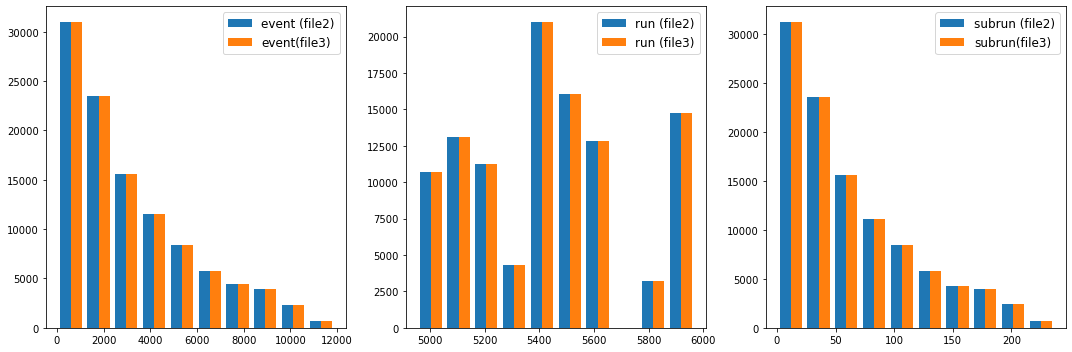

In [5]:
legend_size = 12

plt.figure(figsize=(15,5))

plt.subplot(131)
plt.hist([df_file2_new.event,df_file3_new.event], label=['event (file2)','event(file3)'])
plt.legend(loc='best', prop={'size': legend_size})

plt.subplot(132)
plt.hist([df_file2_new.run,df_file3_new.run], label=['run (file2)','run (file3)'])
plt.legend(loc='best', prop={'size': legend_size})

plt.subplot(133)
plt.hist([df_file2_new.subrun,df_file3_new.subrun], label=['subrun (file2)','subrun(file3)'])
plt.legend(loc='best', prop={'size': legend_size})

plt.tight_layout()

# Compare distributions

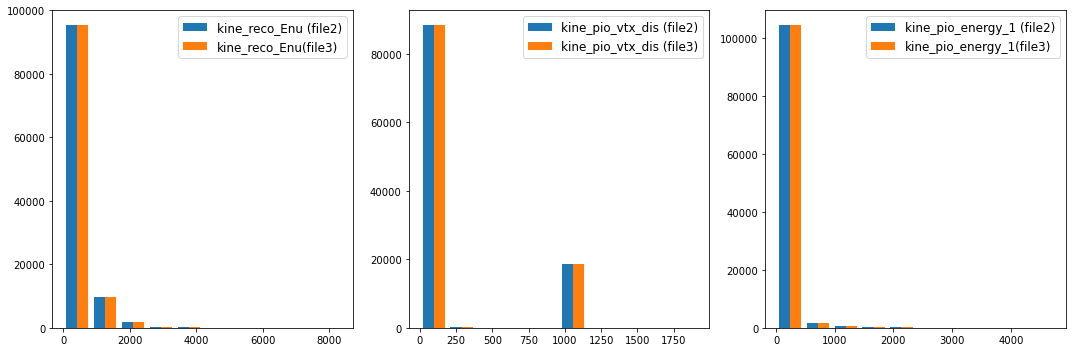

In [6]:
plt.figure(figsize=(15,5))

plt.subplot(131)
plt.hist([df_file2_new.kine_reco_Enu,df_file3_new.kine_reco_Enu], label=['kine_reco_Enu (file2)','kine_reco_Enu(file3)'])
plt.legend(loc='best', prop={'size': legend_size})

plt.subplot(132)
plt.hist([df_file2_new.kine_pio_vtx_dis,df_file3_new.kine_pio_vtx_dis], label=['kine_pio_vtx_dis (file2)','kine_pio_vtx_dis (file3)'])
plt.legend(loc='best', prop={'size': legend_size})

plt.subplot(133)
plt.hist([df_file2_new.kine_pio_energy_1,df_file3_new.kine_pio_energy_1], label=['kine_pio_energy_1 (file2)','kine_pio_energy_1(file3)'])
plt.legend(loc='best', prop={'size': legend_size})

plt.tight_layout()

107221


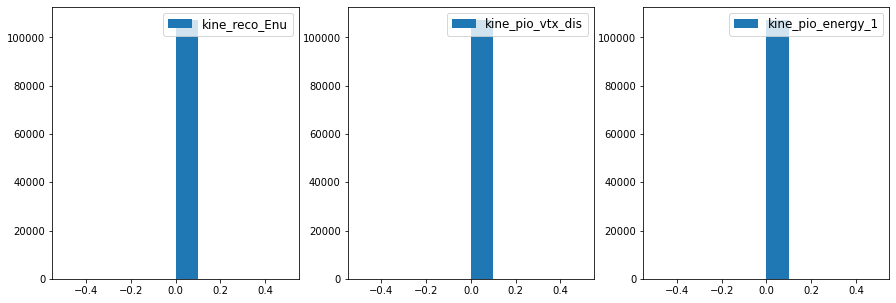

In [7]:
df_combined = pd.merge(df_file2, df_file3, left_on = ['run','subrun','event'], right_on = ['run','subrun','event'], suffixes=['_old','_new'], how='inner') 
print('%i' % len(df_combined))
df_combined.head()

plt.figure(figsize=(15,5))

plt.subplot(131)
abc_kine_reco_Enu = np.array(df_combined['kine_reco_Enu_old'].values) - np.array(df_combined['kine_reco_Enu_new'].values)
plt.hist(abc_kine_reco_Enu, label='kine_reco_Enu')
plt.legend(loc='best', prop={'size': legend_size})

plt.subplot(132)
abc_kine_pio_vtx_dis = np.array(df_combined['kine_pio_vtx_dis_old'].values) - np.array(df_combined['kine_pio_vtx_dis_new'].values)
plt.hist(abc_kine_pio_vtx_dis, label='kine_pio_vtx_dis')
plt.legend(loc='best', prop={'size': legend_size})

plt.subplot(133)
abc_kine_pio_energy_1 = np.array(df_combined['kine_pio_energy_1_old'].values) - np.array(df_combined['kine_pio_energy_1_new'].values)
plt.hist(abc_kine_pio_energy_1, label='kine_pio_energy_1')
plt.legend(loc='best', prop={'size': legend_size})

# Particle multiplicity

In [39]:
#def calc_particle_multiplicity(df):
    
    #abc = np.array[df.truth_Ntrack!=0]
    #nelectrons = df[(df.truth_Ntrack!=0) & (df.truth_pdg[]==11)]
    
    #return nelectrons

#nelectrons = calc_particle_multiplicity(df_file2)
#print('Number of electrons = %i' % len(nelectrons))

abc = np.array(df_file2['truth_mother'].values)
print(abc)

np.count_nonzero(abc==0)

[array([   0,    0,    0,    0,    0,    5,    5,    5,    5,    5,    5,
           5,    5,    5,    5,    5,    5,    5,    4,    4,    1,    1,
           1,    1,    1,    1,    1,    1,    1,    1,    1,    1,    1,
           1,  222,  222,  820,  815,   90,   90, 1630, 1630, 1642, 1632,
        1632, 1729, 1729, 1729, 1729, 1742, 1741, 1737,   89, 1730, 1730,
        1631, 1631, 1631, 1631,   52,   52,   52,   52, 2172, 2172, 2172,
        2172, 2172,   50,   50, 2202, 2202, 2202, 2202, 2202, 2202, 2211,
        2211, 2211, 2211, 2211,   49,   49,   49, 2226, 2226,   46,   46,
          46, 2252, 2252, 2252, 2256, 2256, 2084, 2084, 2457, 2457, 2454,
        2549, 2549, 2549, 2562, 2562, 2559, 2558, 2127, 2124, 2124, 2122,
        3167, 3177, 2109, 3283, 3292, 2108, 2601, 3658, 2493, 2493, 2493,
        2493, 2493, 2493, 2493, 2250, 2250, 3712, 3712, 3712,   45,   45,
          45,   45,   45,   45,   45, 3731, 3731, 3731, 3730, 3730, 3730,
        3730, 3730, 3730, 3730, 3730, 

<ipython-input-39-befba8dbd7ae>:14: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  np.count_nonzero(abc==0)


0

In [49]:
df_file2.loc[:,'Num_neutrons'] = [0]*df_file2.shape[0]
for x,y,w in zip(df_file2.truth_mother, df_file2.truth_pdg, range(len(df_file2.truth_mother))):
    if (len(x) > 0) & ((2112 in y) | (-2112 in y)): 
        index_ = [i for i,z in enumerate(y) if (abs(z) == 2112 and x[i] ==0)]
        df_file2.loc[w,'Num_neutrons'] = len(index_)

In [4]:
DF = df_file2

DF.loc[:,'Num_muons'] = [0]*DF.shape[0]
DF.loc[:,'Num_kaons'] = [0]*DF.shape[0]
DF.loc[:,'Num_pions'] = [0]*DF.shape[0]
DF.loc[:,'Num_protons'] = [0]*DF.shape[0]
DF.loc[:,'Num_photons'] = [0]*DF.shape[0]
DF.loc[:,'Num_electrons'] = [0]*DF.shape[0]
DF.loc[:,'Num_neutrons'] = [0]*DF.shape[0]

pdg_N = 2112
pdg_mu = 13
pdg_k = 321
pdg_pi = 211
pdg_P = 2212
pdg_gamma = 22
pdg_e = 11

for x,y,w in zip(DF.reco_mother, DF.reco_pdg, range(len(DF.reco_mother))):
    if (len(x) > 0) & (pdg_N in y): 
        index_ = [i for i,z in enumerate(y) if (abs(z) == pdg_N and x[i] ==0)]
        DF.loc[w,'Num_neutrons'] = len(index_)
    if (len(x) > 0) & ((pdg_mu in y) | (-pdg_mu in y)): 
        index_ = [i for i,z in enumerate(y) if (abs(z) == pdg_mu and x[i] ==0)]
        DF.loc[w,'Num_muons'] = len(index_)
    if (len(x) > 0) & ((pdg_k in y) | (-pdg_k in y)): 
        index_ = [i for i,z in enumerate(y) if (abs(z) == pdg_k and x[i] ==0)]
        DF.loc[w,'Num_kaons'] = len(index_)
    if (len(x) > 0) & ((pdg_pi in y) | (-pdg_pi in y)): 
        index_ = [i for i,z in enumerate(y) if (abs(z) == pdg_pi and x[i] ==0)]
        DF.loc[w,'Num_pions'] = len(index_)
    if (len(x) > 0) & ((pdg_P in y) | (-pdg_P in y)): 
        index_ = [i for i,z in enumerate(y) if (abs(z) == pdg_P and x[i] ==0)]
        DF.loc[w,'Num_protons'] = len(index_)
    if (len(x) > 0) & (pdg_gamma in y): 
        index_ = [i for i,z in enumerate(y) if (abs(z) == pdg_gamma and x[i] ==0)]
        DF.loc[w,'Num_photons'] = len(index_)
    if (len(x) > 0) & ((pdg_e in y) | (-pdg_e in y)): 
        index_ = [i for i,z in enumerate(y) if (abs(z) == pdg_e and x[i] ==0)]
        DF.loc[w,'Num_electrons'] = len(index_)

In [5]:
columns = ['reco_mother','reco_pdg','Num_neutrons','Num_muons','Num_kaons','Num_pions','Num_protons','Num_photons','Num_electrons']

df_file2.loc[0:10,columns]

,reco_mother,reco_pdg,Num_neutrons,Num_muons,Num_kaons,Num_pions,Num_protons,Num_photons,Num_electrons
entry,,,,,,,,,
0,[],[],0,0,0,0,0,0,0
1,[],[],0,0,0,0,0,0,0
2,[],[],0,0,0,0,0,0,0
3,[],[],0,0,0,0,0,0,0
4,[],[],0,0,0,0,0,0,0
5,[],[],0,0,0,0,0,0,0
6,"[0, 0, 0, 0, 76017, 71018, 72019, 73020, 74021...","[13, 2212, 2212, 2212, 11, 11, 11, 11, 211, 21...",2,1,0,0,3,3,0
7,[],[],0,0,0,0,0,0,0
8,[],[],0,0,0,0,0,0,0
